In [2]:
import findspark
findspark.init()

import pyspark

from secrets1 import username
from secrets1 import password

from pyspark.sql.functions import*
from pyspark.sql import SparkSession
import pandas as pd
import json
import re
from datetime import datetime
import mysql.connector as mariadb
import pyinputplus as pyinput
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


Create spark session

In [3]:
spark = SparkSession.builder.master("local[*]").appName("Capstone app").getOrCreate()

Extract data from JSON to DataFrame

In [8]:
def branch_extract():
    print("Extraxting branch data...")
    branch_df = spark.read.json("json_files/cdw_sapp_branch.json")
    return branch_df
def customer_extract():
    print("Extraxting customer data...")
    customer_df = spark.read.json("json_files/cdw_sapp_custmer.json")
    return customer_df
def credit_extract():
    print("Extraxting credit data...")
    credit_df = spark.read.json("json_files/cdw_sapp_credit.json")
    return credit_df
def credit_pandas_extract():
    print("Extraxting credit data...")
    #Read credit_json file into pandas dataframe
    credit_df_pandas = pd.read_json("json_files/cdw_sapp_credit.json", lines=True)
    return credit_df_pandas

Transformation of customer_df according to mapping document

In [9]:
def customer_transform(customer_df):
    print("Transformation of customer_df according to mapping document...")
    #convert First Name to Title case, Middle name in lower case, Last name in Title case
    customer_transform_df = customer_df.withColumn("FIRST_NAME", initcap(customer_df["FIRST_NAME"]))\
                             .withColumn("MIDDLE_NAME", lower(customer_df["MIDDLE_NAME"]))  \
                             .withColumn("LAST_NAME", initcap(customer_df["LAST_NAME"]))  
                             

    #Concatenate apartment no and street name of customer's residence with comma as a separator
    customer_transform_df = customer_transform_df.withColumn("FULL_STREET_ADDRESS", \
                            concat_ws(",",customer_df["APT_NO"],customer_df["STREET_NAME"]))

    #Drop column APT_NO and STREET_NAME
    customer_transform_df = customer_transform_df.drop("APT_NO","STREET_NAME")

    #change the data type of SSN,CUST_ZIP,CUST_PHONE,LAST_UPDATED
    customer_transform_df = customer_transform_df \
      .withColumn("SSN" ,customer_df["SSN"].cast('int'))   \
      .withColumn("CUST_ZIP",customer_df["CUST_ZIP"].cast('int'))   \
      .withColumn("CUST_PHONE",customer_df["CUST_PHONE"].cast('string'))   \
      .withColumn("LAST_UPDATED",customer_df["LAST_UPDATED"].cast('timestamp')) 

    #change the format of the phone number
    customer_transform_df = customer_transform_df.withColumn("CUST_PHONE", regexp_replace(col("CUST_PHONE") ,\
                             "(\\d{3})(\\d{4})" , "(155)$1-$2" ) )
    return customer_transform_df


Transformation of branch_df according to mapping document

In [10]:
def branch_transform(branch_df):
   print("Transformation of branch data according to mapping document...")
   #change the data type of BRANCH_CODE,BRANCH_ZIP,LAST_UPDATED
   branch_transform_df = branch_df \
      .withColumn("BRANCH_CODE" ,branch_df["BRANCH_CODE"].cast('int'))   \
      .withColumn("BRANCH_ZIP",branch_df["BRANCH_ZIP"].cast('int'))    \
      .withColumn("LAST_UPDATED",branch_df["LAST_UPDATED"].cast('timestamp')) 

   #change the format of the phone number
   branch_transform_df = branch_transform_df.withColumn("BRANCH_PHONE", regexp_replace(col("BRANCH_PHONE") ,\
                         "(\\d{3})(\\d{3})(\\d{4})" , "($1)$2-$3" ) )

   # If source value is null load default value (99999)
   branch_transform_df = branch_transform_df.na.fill(value=99999,subset=["BRANCH_ZIP"])
   return branch_transform_df


In [11]:
def branch_transform1(branch_df):
    print("Transformation of branch data according to mapping document...")
    branch_df.createOrReplaceTempView("branchview")
    branch_transform_df = spark.sql("SELECT CAST(BRANCH_CODE AS INT), BRANCH_NAME, BRANCH_STREET, BRANCH_CITY, \
                          BRANCH_STATE, CAST(IF(BRANCH_ZIP IS NULL, '99999', BRANCH_ZIP) AS INT) AS BRANCH_ZIP, \
                          CONCAT('(', SUBSTR(BRANCH_PHONE, 1, 3), ')', SUBSTR(BRANCH_PHONE, 4,3), '-', SUBSTR(BRANCH_PHONE, 7, 4)) AS BRANCH_PHONE, \
                          CAST(LAST_UPDATED AS TIMESTAMP) FROM BRANCHVIEW")
    return branch_transform_df


Transformation of credit_df according to mapping document - pandas

In [12]:
def credit_transform(credit_df_pandas):
    print("Transformation of credit data according to mapping document...")
    #change the data type of DAY,MONTH,YEAR
    credit_transform_df_pandas = credit_df_pandas.astype({"DAY":'str',"MONTH":'str',"YEAR":'str',"CREDIT_CARD_NO":'str'})
    credit_transform_df_pandas['DAY'] = credit_transform_df_pandas["DAY"].str.pad(2,side='left',fillchar='0')
    credit_transform_df_pandas['MONTH'] = credit_transform_df_pandas["MONTH"].str.pad(2,side='left',fillchar='0')
    
    #Converting DAY, MONTH, YEAR into a TIMEID (YYYYMMDD)
    credit_transform_df_pandas['TIMEID'] = credit_transform_df_pandas["YEAR"] + credit_transform_df_pandas["MONTH"] \
                                            + credit_transform_df_pandas["DAY"]
    
    #Drop column APT_NO and STREET_NAME
    credit_transform_df_pandas.drop(["DAY","MONTH","YEAR"],axis = 1,inplace = True)
    
    #Rename column CREDIT_CARD_NO to CUST_CC_NO 
    credit_transform_df_pandas.rename(columns = {"CREDIT_CARD_NO":"CUST_CC_NO"}, inplace = True)

    #converting pandas Dataframe to pyspark Dataframe
    credit_transform_df = spark.createDataFrame(credit_transform_df_pandas)

    #change the data type of BRANCH_CODE,CUST_SSN,TRANSACTION_ID
    credit_transform_df = credit_transform_df \
    .withColumn("BRANCH_CODE",credit_transform_df["BRANCH_CODE"].cast('int'))   \
    .withColumn("CUST_SSN",credit_transform_df["CUST_SSN"].cast('int'))   \
    .withColumn("TRANSACTION_ID",credit_transform_df["TRANSACTION_ID"].cast('int')) 

    return credit_transform_df


Data loading into Database

In [13]:
def branch_load(branch_transform_df):
       print("Loading transformed branch data into Database...")
       branch_transform_df.write.format("jdbc") \
       .mode("append") \
       .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
       .option("createTableColumnTypes", "BRANCH_NAME VARCHAR(30), BRANCH_CITY VARCHAR(30),\
              BRANCH_STREET VARCHAR(30), BRANCH_STATE VARCHAR(30) ,BRANCH_PHONE VARCHAR(14) ")  \
       .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
       .option("user", username) \
       .option("password", password) \
       .option("characterEncoding","UTF-8") \
       .option("useUnicode", "true") \
       .save()

def credit_load(credit_transform_df):
       print("Loading transformed credit data into Database...")
       credit_transform_df.write.format("jdbc") \
        .mode("append") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("createTableColumnTypes", "CUST_CC_NO VARCHAR(30), TRANSACTION_TYPE VARCHAR(30),\
               TIMEID VARCHAR(30)")  \
        .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
        .option("user", username) \
        .option("password", password) \
        .option("characterEncoding","UTF-8") \
        .option("useUnicode", "true") \
        .save()

def customer_load(customer_transform_df):
       print("Loading transformed customer data into Database...")
       customer_transform_df.write.format("jdbc") \
        .mode("append") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("createTableColumnTypes", "FIRST_NAME VARCHAR(30), MIDDLE_NAME VARCHAR(30),\
               LAST_NAME VARCHAR(30),CREDIT_CARD_NO VARCHAR(30),FULL_STREET_ADDRESS VARCHAR(50), \
               CUST_CITY VARCHAR(30),CUST_STATE VARCHAR(30),CUST_COUNTRY VARCHAR(30),  \
               CUST_PHONE VARCHAR(30),CUST_EMAIL VARCHAR(30)")  \
        .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
        .option("user", username) \
        .option("password", password) \
        .option("characterEncoding","UTF-8") \
        .option("useUnicode", "true") \
        .save()

In [14]:
# Log that you have started the ETL process
print("ETL Job Started")

# Log that you have started the Extract step
print("Extract phase Started")

# Call the Extract function
extracted_customer_data = customer_extract()
extracted_branch_data = branch_extract()
extracted_credit_data = credit_pandas_extract()

# Log that you have completed the Extract step
print("Extract phase Ended")

# Log that you have started the Transform step
print("Transform phase Started")

# Call the Transform function
customer_transformed_data = customer_transform(extracted_customer_data)
branch_transformed_data = branch_transform(extracted_branch_data)
credit_transformed_data = credit_transform(extracted_credit_data)

# Log that you have completed the Transform step
print("Transform phase Ended")

# Log that you have started the Load step
print("Load phase Started")

# Call the Load function
customer_load(customer_transformed_data)
branch_load(branch_transformed_data)
credit_load(credit_transformed_data)


# Log that you have completed the Load step
print("Load phase Ended")

# Log that you have completed the ETL process
print("ETL Job Ended")

ETL Job Started
Extract phase Started
Extraxting customer data...
Extraxting branch data...
Extraxting credit data...
Extract phase Ended
Transform phase Started
Transformation of customer_df according to mapping document...
Transformation of branch data according to mapping document...
Transformation of credit data according to mapping document...


C:\Spark\python\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Transform phase Ended
Load phase Started
Loading transformed customer data into Database...
Loading transformed branch data into Database...
Loading transformed credit data into Database...
Load phase Ended
ETL Job Ended


2.1 Transaction Details Module


In [4]:
def load_from_db():
    branch_df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=username,\
                                     password=password,\
                                     url="jdbc:mysql://localhost:3306/companyabc_db",\
                                     dbtable="creditcard_capstone.CDW_SAPP_BRANCH").load()

    credit_df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=username,\
                                     password=password,\
                                     url="jdbc:mysql://localhost:3306/companyabc_db",\
                                     dbtable="creditcard_capstone.CDW_SAPP_CREDIT_CARD").load()

    customer_df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=username,\
                                     password=password,\
                                     url="jdbc:mysql://localhost:3306/companyabc_db",\
                                     dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER").load()
    return(branch_df,credit_df,customer_df)

In [ ]:
customer_df.createOrReplaceTempView("customerview")
branch_df.createOrReplaceTempView("branchview")
credit_df.createOrReplaceTempView("creditview")

In [51]:
#Validation

def common_validator(display_text_user, validator_method):
    is_valid_input = True
    while is_valid_input:
        user_input_value = input(display_text_user)
        is_valid_input = validator_method(user_input_value)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True

def tr_type_validator(display_text_user, validator_method,validator_list):
    is_valid_input = True
    while is_valid_input:
        user_input_value = input(display_text_user).title()
        is_valid_input = validator_method(user_input_value,validator_list)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True

def state_validator(display_text_user, validator_method,validator_list):
    is_valid_input = True
    while is_valid_input:
        user_input_value = input(display_text_user).upper()
        is_valid_input = validator_method(user_input_value,validator_list)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True

def validate_zip_code(zip_code):
    pattern = r'^\d{5}'
    return bool(re.match(pattern, str(zip_code)))

def validate_month(month):
    return True if month.isnumeric() and int(month) in list(range(1,13)) else False
    #return True if month.isnumeric() and month in range(1,13) else False

def validate_year(year):
    return True if year.isnumeric() and int(year)==2018 else False

def validate_cc_no(cc_number):
    return True if cc_number.isnumeric() and len(cc_number) == 16 else False

def validate_ph_no(ph_no):
    return True if ph_no.isnumeric() and len(ph_no) == 10 else False

def validate_transaction_type(tr_type,tr_type_list):
    return True if tr_type.isalpha() and tr_type in tr_type_list else False

def validate_transaction_type(tr_type,tr_type_list):
    return True if tr_type.isalpha() and tr_type in tr_type_list else False

def validate_state(state_input,state_list):
    return True if state_input.isalpha() and state_input in state_list else False

In [52]:
#display the transactions made by customers living in agiven zip code for a given month and year. Order by d
#descending order.

zipcode_input = common_validator("Enter 5-digit zip_code: ", validate_zip_code)
month_input = common_validator("Enter month(in digits): ", validate_month)
year_input = common_validator("Enter year: ", validate_year)

#add padding for the month variable
month_input = month_input.rjust(2,'0')

query = f"select * from creditview AS credit JOIN customerview \
        AS customer on customer.CREDIT_CARD_NO = credit.CUST_CC_NO WHERE \
        customer.CUST_ZIP = {zipcode_input} AND month(to_timestamp(TIMEID,'yyyyMMdd')) = '{month_input}' \
        AND YEAR(to_timestamp(TIMEID,'yyyyMMdd')) = '{year_input}' order by day(credit.TIMEID) desc"

print(query)
spark.sql(query).show()

select * from creditview AS credit JOIN customerview         AS customer on customer.CREDIT_CARD_NO = credit.CUST_CC_NO WHERE         customer.CUST_ZIP = 39120 AND month(to_timestamp(TIMEID,'yyyyMMdd')) = '04'         AND YEAR(to_timestamp(TIMEID,'yyyyMMdd')) = '2018' order by day(credit.TIMEID) desc
+--------------+----------------+---------+-----------+----------------+-----------------+--------+----------------+---------+-------------+--------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|TRANSACTION_ID|      CUST_CC_NO| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+--------------+----------------+---------+-----------+----------------+-----------------+--------+----------------+---------+------------

In [18]:
#display the number and total values of transactions for a given type.

#get unique transaction type list
tr_type_query = f"select distinct(TRANSACTION_TYPE) from creditview"
tr_type_df= spark.sql(tr_type_query)
tr_type_list = tr_type_df.select('TRANSACTION_TYPE').rdd.map(lambda row : row[0]).collect()

tr_type_input = tr_type_validator("Enter Transaction Type: ", validate_transaction_type,tr_type_list)

#query = f"SELECT TRANSACTION_ID, SUM(TRANSACTION_VALUE) \
            #  FROM creditview \
            #  WHERE TRANSACTION_TYPE = '{tr_type}' \
            #  GROUP BY TRANSACTION_ID"

query = f"SELECT count(TRANSACTION_ID), SUM(TRANSACTION_VALUE) \
             FROM creditview \
             WHERE TRANSACTION_TYPE = '{tr_type_input}' \
             GROUP BY TRANSACTION_TYPE"
print(query)
spark.sql(query).show()	

SELECT count(TRANSACTION_ID), SUM(TRANSACTION_VALUE)              FROM creditview              WHERE TRANSACTION_TYPE = 'Healthcare'              GROUP BY TRANSACTION_TYPE
+---------------------+----------------------+
|count(TRANSACTION_ID)|sum(TRANSACTION_VALUE)|
+---------------------+----------------------+
|                 6723|     340476.1999999994|
+---------------------+----------------------+



In [47]:
#display the number and total values of transactions for branches in a given state

#get state list
state_query = f"select distinct(CUST_STATE) from customerview"
state_df= spark.sql(state_query)
state_list =state_df.select('CUST_STATE').rdd.map(lambda row : row[0]).collect()

state_input = state_validator("Enter two letter state code: ", validate_state,state_list)

# query = f"SELECT branch_state,credit.TRANSACTION_ID, SUM(credit.TRANSACTION_VALUE) \
            #  FROM cdw_sapp_branch AS branch INNER JOIN cdw_sapp_credit_card AS credit \
            #  ON branch.BRANCH_CODE = credit.BRANCH_CODE WHERE branch_state= '{state}' \
            #  GROUP BY credit.TRANSACTION_ID GROUP BY branch.branch_code"
query= f"SELECT branch.BRANCH_CODE,count(TRANSACTION_ID),sum(TRANSACTION_VALUE) FROM branchview \
         AS branch INNER JOIN creditview AS credit ON branch.BRANCH_CODE = credit.BRANCH_CODE \
         WHERE BRANCH_STATE= '{state_input}' group by branch.BRANCH_CODE"

spark.sql(query).show()	

+-----------+---------------------+----------------------+
|BRANCH_CODE|count(TRANSACTION_ID)|sum(TRANSACTION_VALUE)|
+-----------+---------------------+----------------------+
|          1|                  374|    18157.569999999992|
|         20|                  381|    19350.830000000024|
|        124|                  372|    18644.890000000003|
+-----------+---------------------+----------------------+



2.2 Customer Details Module


In [10]:
def account_details():
    #check the existing account details of a customer.
    cc_no_input = common_validator("Enter 16-digit credit card number: ", validate_cc_no)
    phone_no_input = common_validator("Enter phone number: ", validate_ph_no)
    
    #phone_input = re.sub(r"^(\d+)-", r"(\1)",phone_input)
    formatted_phone_input= f"({phone_no_input[:3]}){phone_no_input[3:6]}-{phone_no_input[6:10]}"
    
    query= f"SELECT * from customerview where CREDIT_CARD_NO = '{cc_no_input}' and CUST_PHONE = '{formatted_phone_input}'"
    
    spark.sql(query).show()
    return cc_no_input,phone_no_input


+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|4210653310061055|  Natchez|United States|AHooper@example.com|(155)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21 11:49:02|         wm|123456100|656,Main Street N...|
|4210653310061055|  Natchez|United States|AHooper@example.com|(155)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21 11:49:02|         wm|123456100|656,Main Street N...|
+----------------+---------+-------------+-------------------+-------------+----------+--------

In [50]:
def db_connectivity(update_query_variable,user_update_input,credit_card_no_input,formatted_phone_input):
    con=mariadb.connect(host="localhost",user=username,password=password,database="creditcard_capstone")
    cur=con.cursor()
    st=f"update cdw_sapp_customer set {update_query_variable} = '{user_update_input}'\
         where CREDIT_CARD_NO = '{credit_card_no_input}' and CUST_PHONE = '{formatted_phone_input}' "
    cur.execute(st)
    con.commit()
    cur.close()
    con.close()



In [52]:
#modify the existing account details of a customer
#check the existing account details of a customer.
acc_no,phone_number = account_details()

#Get user input

display_text = ('''Enter choice from below to update:
         1.Update Phone Number
         2.Update First Name
         3.Update Lirst Name
         4.Update Middle Name
         5.Update Email
         6.Update Full_Street_Address
         7.Update city
         8.Update state
         9.Update Contry
         10.Update Zip_Code
         11.Exit''')

while True:
    user_choice = input(display_text + "Please enter your choice: ")
    if user_choice.isspace():
        print(" Invalid user choice ")
        user_choice = 0
    elif user_choice not in range(1,13):
        print("Invalid user choice ")
        user_choice=0
    elif int(user_choice) == 1:
        update_query_variable = "CUST_PHONE"
    elif int(user_choice) == 2:
        update_query_variable = "FIRST_NAME"
    elif int(user_choice) == 3:
        update_query_variable = "LAST_NAME"
    elif int(user_choice) == 4:
        update_query_variable = "MIDDLE_NAME"
    elif int(user_choice) == 5:
        update_query_variable = "CUST_EMAIL"
    elif int(user_choice) == 6:
        update_query_variable = "FULL_STREET_ADDRESS"
    elif int(user_choice) == 7:
        update_query_variable = "CUST_CITY"
    elif int(user_choice) == 8:
        update_query_variable = "CUST_STATE"
    elif int(user_choice) == 9:
        update_query_variable = "CUST_COUNTRY"
    elif int(user_choice) == 10:
        update_query_variable = "CUST_ZIP"
    elif int(user_choice) == 11:
        print("Exiting")
        exit


user_update_input = input(f"Enter {update_query_variable} value to update: ")
db_connectivity(update_query_variable,user_update_input,credit_card_no_input,formatted_phone_input)

+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|4210653310061055|  Natchez|United States|AHooper@example.com|(155)123-7818|        MS|   39120|      Blec|   Hooper|2023-02-20 14:45:02|         wm|123456100|656,Main Street N...|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+

Exiting


In [32]:
#generate a monthly bill for a credit card number for a given month and year.

credit_card_input = input("Enter credit card number: ")
month_input = input("Enter month:" )
year_input = input("Enter year: ")

qurey = query = f"SELECT CUST_CC_NO, ROUND(SUM(TRANSACTION_VALUE),2) as Monthly_Bill FROM creditview \
                  WHERE MONTH(to_date(TIMEID, 'yyyyMMdd')) = {month_input} AND \
                  YEAR(to_date(TIMEID, 'yyyyMMdd')) = {year_input} and CUST_CC_NO={credit_card_input} \
                  GROUP BY CUST_CC_NO"
print(query)
spark.sql(query).show()

SELECT CUST_CC_NO, ROUND(SUM(TRANSACTION_VALUE),2) as Monthly_Bill FROM creditview                   WHERE MONTH(to_date(TIMEID, 'yyyyMMdd')) = 08 AND                   YEAR(to_date(TIMEID, 'yyyyMMdd')) = 2018 and CUST_CC_NO=4210653312478046                   GROUP BY CUST_CC_NO
+----------------+------------+
|      CUST_CC_NO|Monthly_Bill|
+----------------+------------+
|4210653312478046|      475.54|
+----------------+------------+



In [34]:
#display the transactions made by a customer between two dates. Order by year, month, and day in descending order.
credit_card_input = input("Enter credit card number: ")
start_date_input = input("Enter start date: ")
end_date_input = input("Enter End Date: ")

query = f"SELECT TRANSACTION_ID,CUST_CC_NO,BRANCH_CODE,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID FROM creditview \
        WHERE to_date(TIMEID, 'yyyyMMdd') >= '{start_date_input}' \
        AND to_date(TIMEID, 'yyyyMMdd') <= '{end_date_input}' \
        AND cust_cc_no = {credit_card_input} ORDER BY \
        YEAR(to_date(TIMEID, 'yyyyMMdd')) DESC, MONTH(to_date(TIMEID, 'yyyyMMdd')) DESC, \
        DAY(to_date(TIMEID, 'yyyyMMdd')) DESC"
query1=f"select * from creditview"
print(query)
spark.sql(query).show()


SELECT TRANSACTION_ID,CUST_CC_NO,BRANCH_CODE,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID FROM creditview         WHERE to_date(TIMEID, 'yyyyMMdd') >= '2018-04-02'         AND to_date(TIMEID, 'yyyyMMdd') <= '2018-08-08'         AND cust_cc_no = 4210653315516879 ORDER BY         YEAR(to_date(TIMEID, 'yyyyMMdd')) DESC, MONTH(to_date(TIMEID, 'yyyyMMdd')) DESC,         DAY(to_date(TIMEID, 'yyyyMMdd')) DESC
+--------------+----------------+-----------+----------------+-----------------+--------+
|TRANSACTION_ID|      CUST_CC_NO|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|
+--------------+----------------+-----------+----------------+-----------------+--------+
|           164|4210653315516879|        119|         Grocery|            42.15|20180802|
|           156|4210653315516879|        170|            Test|            90.94|20180626|
|           168|4210653315516879|         22|           Bills|             9.19|20180616|
|           152|4210653315516879|         78|      Health

3 - Functional Requirements - Data analysis and Visualization

In [5]:
def load_to_pandas(branch_df,credit_df,customer_df):
    branch_df_pandas = branch_df.toPandas()
    credit_df_pandas = credit_df.toPandas()
    customer_df_pandas = customer_df.toPandas()
    return (branch_df_pandas,credit_df_pandas,customer_df_pandas)


In [6]:
#plot which transaction type has a high rate of transactions.
branch_df,credit_df,customer_df=load_from_db()
branch_df_pandas,credit_df_pandas,customer_df_pandas=load_to_pandas(branch_df,credit_df,customer_df)


C:\Spark\python\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\Spark\python\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


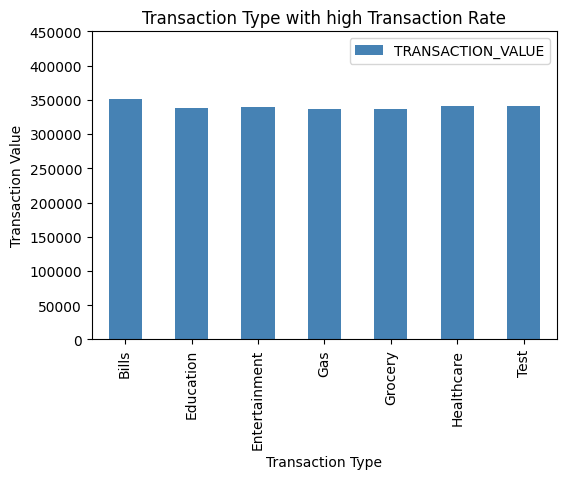

In [20]:
tr_rate_df = credit_df_pandas[["TRANSACTION_TYPE","TRANSACTION_VALUE"]]
tr_rate_df = tr_rate_df.groupby(['TRANSACTION_TYPE']).sum()
tr_rate_df.reset_index(inplace = True)
tr_rate_df.head()
tr_rate_df.plot(x = "TRANSACTION_TYPE", y="TRANSACTION_VALUE", kind = "bar",color='SteelBlue',figsize=(6, 4))
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Value")
plt.title("Transaction Type with high Transaction Rate")
#plt.grid(linestyle='dashed', axis="both")
plt.yticks(list(range(0,500000,50000)))
#plt.yticks([100000,200000,300000,400000,500000])
#plt.xticks(np.arange(1,13,2))
plt.show()


plot which state has a high number of customers.

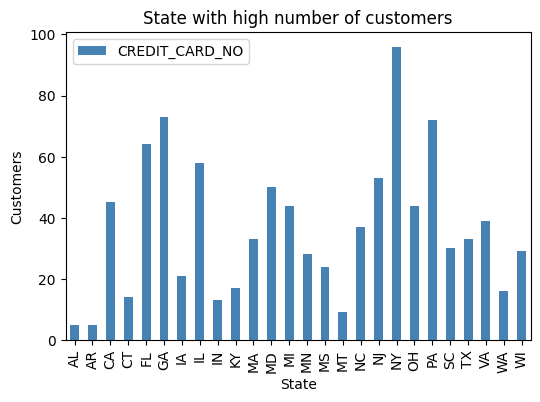

In [21]:
st_cust_df = customer_df_pandas[["CUST_STATE","CREDIT_CARD_NO"]]
st_cust_df = st_cust_df.groupby(['CUST_STATE']).count()
st_cust_df.reset_index(inplace = True)
st_cust_df.head()
st_cust_df.plot(x = "CUST_STATE", y="CREDIT_CARD_NO", kind = "bar",color='SteelBlue',figsize=(6, 4))
plt.xlabel("State")
plt.ylabel("Customers")
plt.title("State with high number of customers")
#plt.grid(linestyle='dashed', axis="both")
#plt.yticks(list(range(0,500000,50000)))
#plt.yticks([100000,200000,300000,400000,500000])
#plt.xticks(np.arange(1,13,2))
plt.show()


sum of all transactions for the top 10 customers,and which customer has the highest transaction amount.